# Exercise: Image classification with medical image

In [1]:
# 安裝所需套件
!pip -q install torchio
!pip -q install transformers==4.28.1 datasets evaluate accelerate

## Import packages

In [2]:
# 匯入基本操作相關套件
import torchio as tio
import glob
import numpy as np
import matplotlib.pyplot as plt

# 匯入 PyTorch 相關套件
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Load dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("/home/jovyan/ta-shared-ii/datas/chest_xray")

Resolving data files:   0%|          | 0/5000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/232 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/624 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/jovyan/.cache/huggingface/datasets/imagefolder/chest_xray-1ebb45d62eb1f2f0/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 232
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})

In [5]:
train_dataset = dataset['train']
valid_dataset = dataset['validation']

In [6]:
item = next(iter(train_dataset))

0


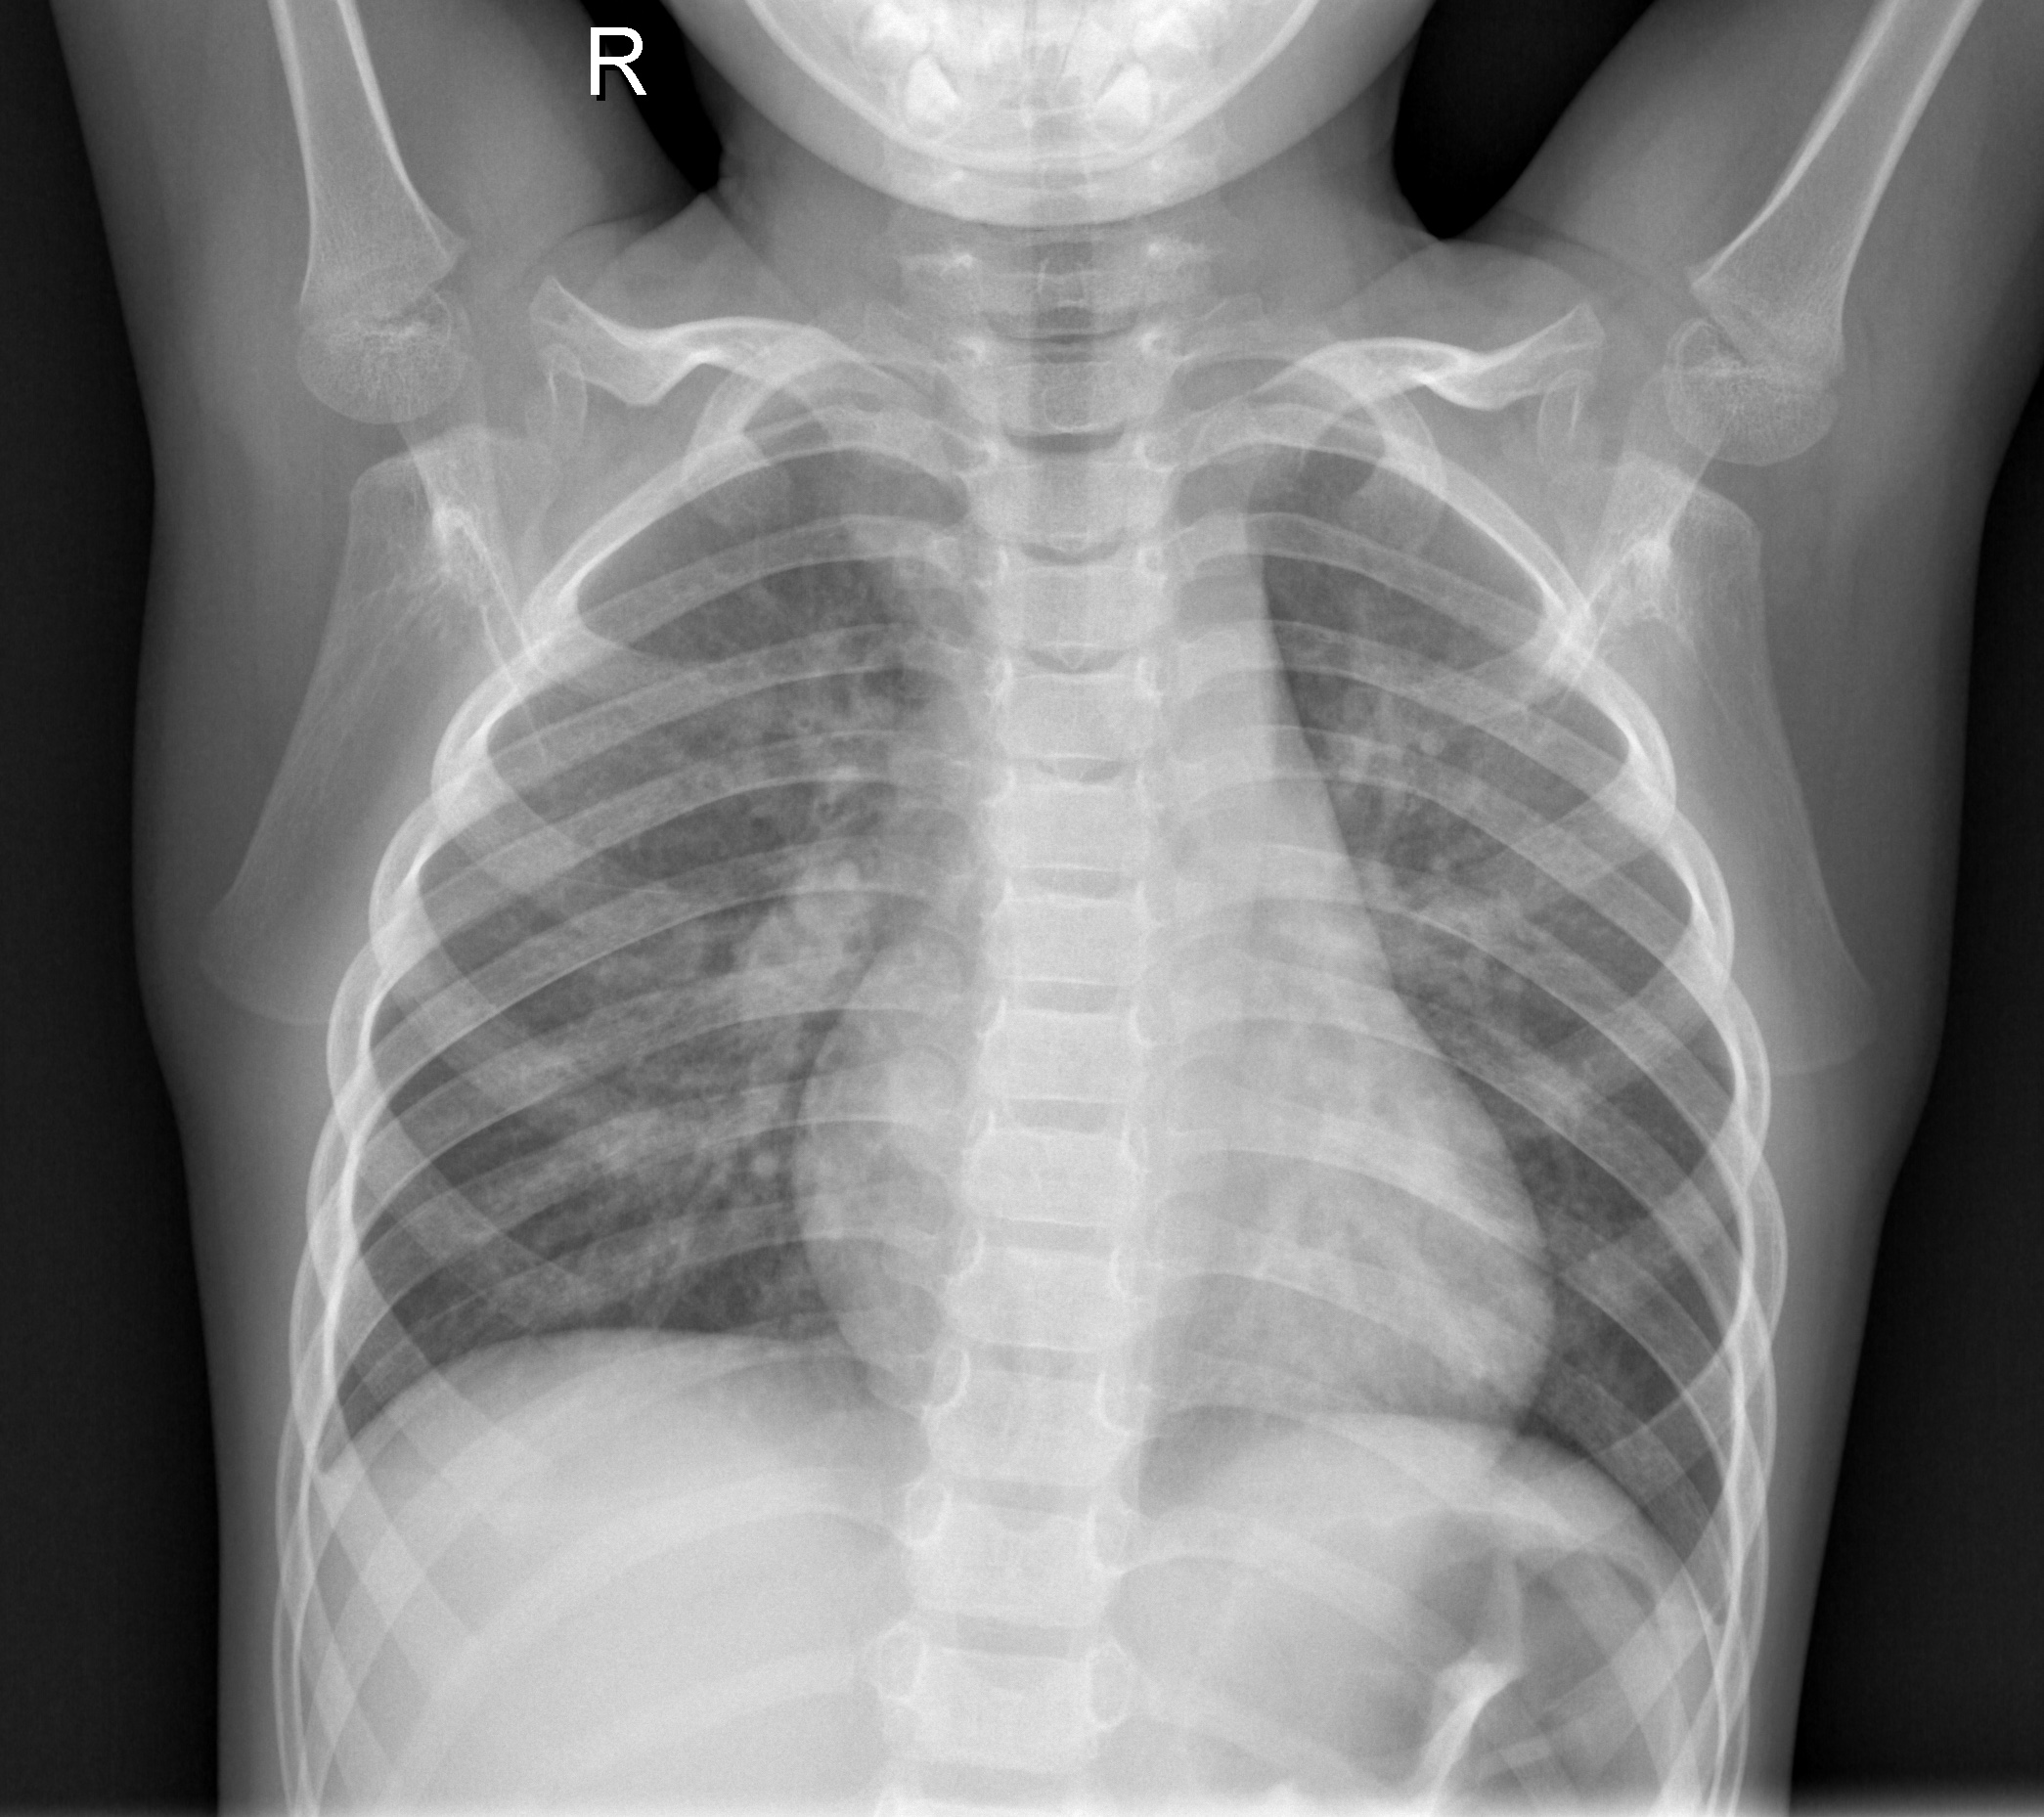

In [7]:
print(item['label'])
item['image']

In [8]:
train_dataset.features["label"].names

['NORMAL', 'PNEUMONIA']

In [9]:
labels = train_dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [10]:
labels

['NORMAL', 'PNEUMONIA']

現在，按照標籤 id 轉換成名稱：

In [11]:
id2label[1]

'PNEUMONIA'

## Preprocess


接下來的步驟是載入指定模型使用的影像處理器，將影像處理成張量：

In [61]:
from transformers import AutoImageProcessor

# checkpoint = "google/vit-base-patch16-224-in21k"  # model name
# checkpoint = "google/efficientnet-b6"
# checkpoint = "microsoft/cvt-13"
checkpoint = "google/mobilenet_v2_1.0_224"
# checkpoint = "microsoft/resnet-50"
# checkpoint = "facebook/convnext-tiny-224"
# checkpoint = "facebook/convnext-base-224"
# # checkpoint = "facebook/convnext-large-224"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [62]:
image_processor

MobileNetV2ImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "MobileNetV2ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

---
將影像進行轉換，使模型更具一般性以應付過擬合的情況。這裡會使用的 torchvision 中 transforms 的模組，但也能替換成其他適用的影像處理套件。

將其調整影像大小以及隨機仿射處理，並使用影像的平均值和標準差進行標準化：

In [63]:
from torchvision.transforms import Resize, RandomAffine, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (image_processor.crop_size['height'], image_processor.crop_size['width'])

# size = (
#     image_processor.size["shortest_edge"]
#     if "shortest_edge" in image_processor.size
#     else (image_processor.size["height"], image_processor.size["width"])
# )
_transforms = Compose([Resize(size),
#                        RandomHorizontalFlip(),
                       RandomAffine(degrees=10, scale=(0.9, 1.1)),
                       ToTensor(),
                       normalize])

接下來創建一個預處理函數，轉換並回傳影像的像素值作為模型的輸入：

In [64]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

要在整個資料集上應用預處理函數，可以使用 Hugging Face 資料集的 [with_transform](https://huggingface.co/docs/datasets/v2.11.0/en/package_reference/main_classes#datasets.Dataset.with_transform) 方法。當載入資料集的一個元素時，轉換會即時套用：

In [65]:
train_ds = train_dataset.with_transform(transforms)
valid_ds = valid_dataset.with_transform(transforms)

In [66]:
import matplotlib.pyplot as plt
import torch

In [67]:
item = next(iter(train_ds))

In [68]:
item

{'label': 0,
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]])}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([3, 224, 224])


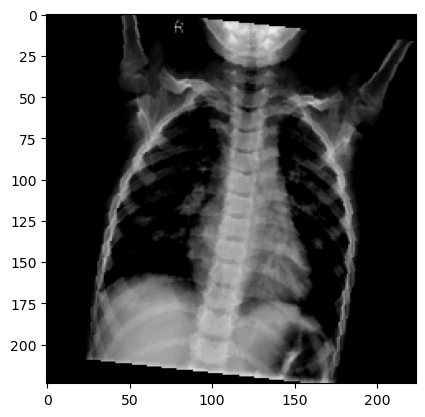

In [69]:
print(item['label'])
print(item['pixel_values'].size())
plt.imshow(torch.permute(item['pixel_values'], (1, 2, 0)))

現在使用 [DefaultDataCollator](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/data_collator#transformers.DefaultDataCollator) 創建一個批次樣本。與 Hugging face 裡 Transformers 的其他資料收集器不同，DefaultDataCollator 不會套用額外的預處理，例如填充（padding）。

In [70]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Evaluate

In [71]:
import evaluate

accuracy = evaluate.load("accuracy")

然後創建一個函數，將預測及標籤使用 [compute](https://huggingface.co/docs/evaluate/v0.4.0/en/package_reference/main_classes#evaluate.EvaluationModule.compute) 以計算準確度：

In [72]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Build model

現在已準備好開始訓練模型了！使用 [AutoModelForImageClassification](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/auto#transformers.AutoModelForImageClassification) 載入模型。指定標籤的數量以及標籤的對應方式：

In [73]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train model

接著的階段，只剩以下三個步驟：

1. 在 [TrainingArguments](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments) 中定義訓練的超參數。請務必留意資料集中未使用的資訊，設定 remove_unused_columns=False 可以防止被刪除未使用到的資訊！例如 image，這會導致無法獲得 pixel_values。另一個必需設定的參數是 output_dir，指定模型儲存的位置。通過設定 push_to_hub=True 將模型上傳至 Hub（需要登入 Hugging Face 才能上傳模型）。在每個 epoch 結束時，[Trainer](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer) 將評估準確性並儲存訓練模型。
2. 將訓練參數、模型、資料集、預處理器、資料收集器以及計算評估指標函數傳遞給 [Trainer](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer)。
3. 呼叫 [train](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer.train) 來微調模型。

In [74]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="my_model_exercise",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")

In [75]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [76]:
from transformers.integrations import MLflowCallback
trainer.remove_callback(MLflowCallback)
trainer.train()

TrainOutput(global_step=785, training_loss=0.07779546300317072, metrics={'train_runtime': 473.2428, 'train_samples_per_second': 52.827, 'train_steps_per_second': 1.659, 'total_flos': 5.02710985728e+16, 'train_loss': 0.07779546300317072, 'epoch': 5.0})

# Inference

現在，微調後的模型以存放在指定路徑，並可使用它來進行推論！

載入想要進行推論的影像：

In [85]:
test_dataset = dataset['test']
image = test_dataset['image'][1]
label = test_dataset['label'][1]

In [86]:
label

0

In [87]:
id2label[label]

'NORMAL'

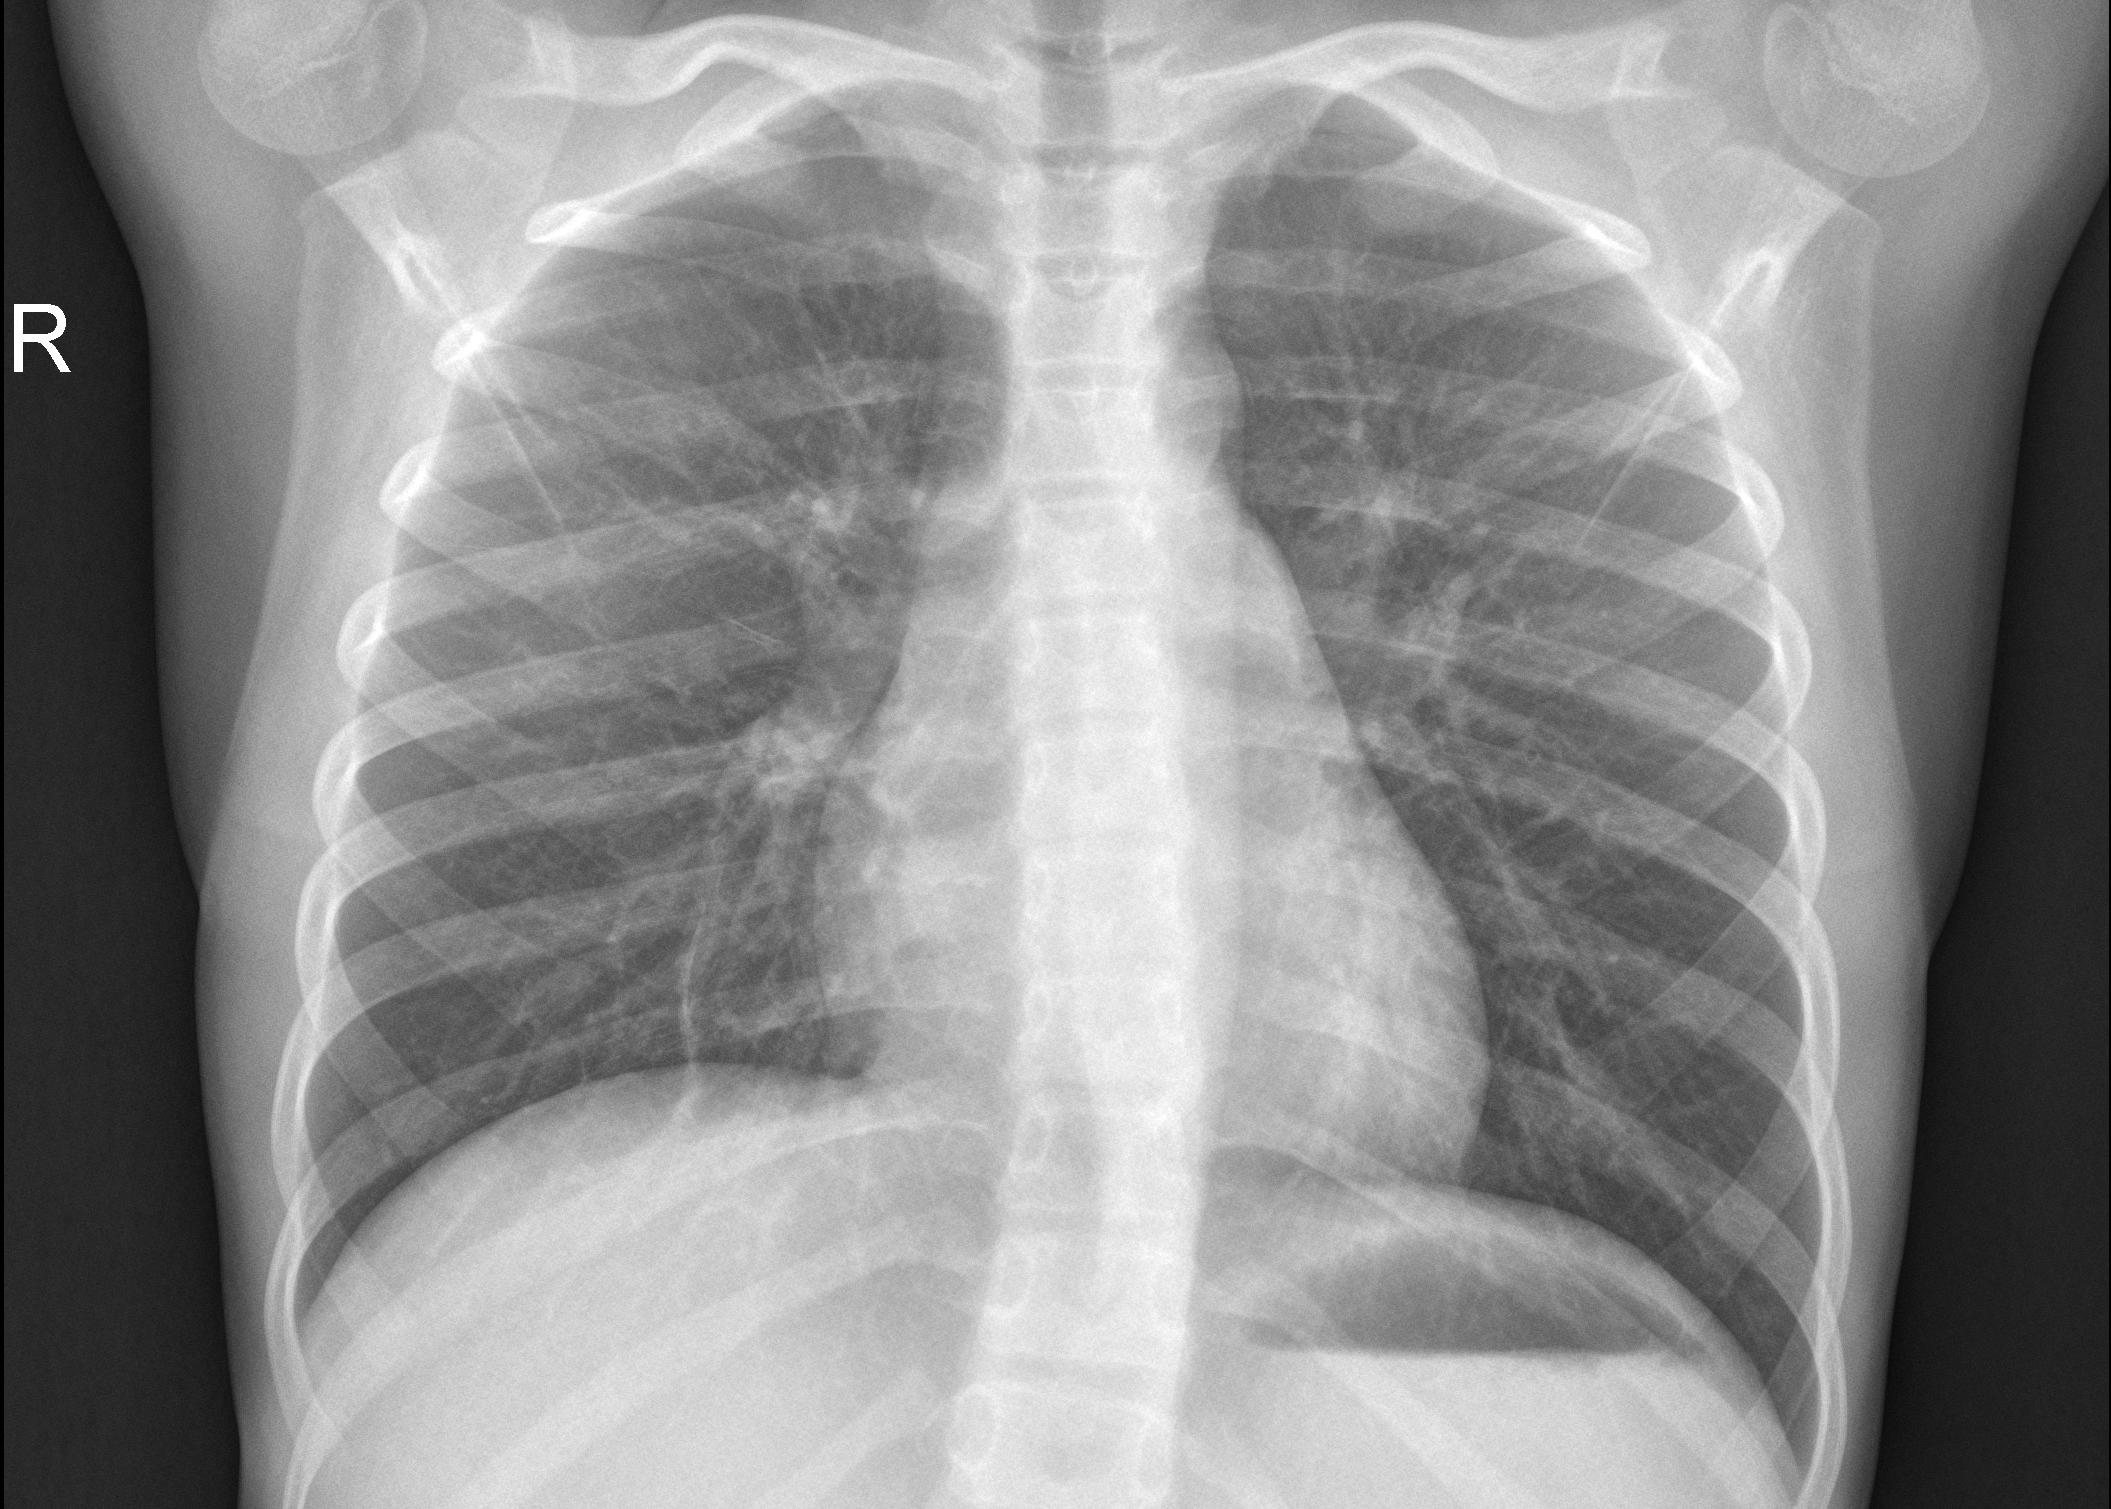

In [88]:
image

使用微調後的模型進行推論最簡單的方法是在 pipline() 中設定。藉由指定的模型建構一個影像分類的 pipeline，然後將影像傳遞給它：

In [89]:
from transformers import pipeline

classifier = pipeline("image-classification", model="my_model_exercise/checkpoint-785")
classifier(image)

[{'score': 0.8651155829429626, 'label': 'NORMAL'},
 {'score': 0.13488443195819855, 'label': 'PNEUMONIA'}]

將輸入傳遞給模型，並回傳 logits（尚未經過 softmax）：

載入影像處理器對影像進行預處理，並以 PyTorch 的張量型態回傳作為輸入：

In [98]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_model_exercise/checkpoint-785")
inputs = image_processor(image.convert('RGB'), return_tensors="pt")

In [91]:
inputs

{'pixel_values': tensor([[[[0.2784, 0.3098, 0.3176,  ..., 0.4431, 0.4275, 0.3882],
          [0.2784, 0.3176, 0.2863,  ..., 0.4588, 0.4431, 0.4275],
          [0.2784, 0.2706, 0.2627,  ..., 0.4667, 0.4588, 0.4588],
          ...,
          [0.4980, 0.5059, 0.5373,  ..., 0.5216, 0.4980, 0.4980],
          [0.4980, 0.5373, 0.5608,  ..., 0.5294, 0.4980, 0.4902],
          [0.5059, 0.5529, 0.5529,  ..., 0.5137, 0.4902, 0.4745]],

         [[0.2784, 0.3098, 0.3176,  ..., 0.4431, 0.4275, 0.3882],
          [0.2784, 0.3176, 0.2863,  ..., 0.4588, 0.4431, 0.4275],
          [0.2784, 0.2706, 0.2627,  ..., 0.4667, 0.4588, 0.4588],
          ...,
          [0.4980, 0.5059, 0.5373,  ..., 0.5216, 0.4980, 0.4980],
          [0.4980, 0.5373, 0.5608,  ..., 0.5294, 0.4980, 0.4902],
          [0.5059, 0.5529, 0.5529,  ..., 0.5137, 0.4902, 0.4745]],

         [[0.2784, 0.3098, 0.3176,  ..., 0.4431, 0.4275, 0.3882],
          [0.2784, 0.3176, 0.2863,  ..., 0.4588, 0.4431, 0.4275],
          [0.2784, 0.2706

將輸入傳遞給模型，並回傳 logits（尚未經過 softmax）：

In [99]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_model_exercise/checkpoint-785")
with torch.no_grad():
    logits = model(**inputs).logits

In [100]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'NORMAL'

In [101]:
model.config.id2label[label]

'NORMAL'